In [1]:
%matplotlib widget
import matplotlib.pylab as plt
import numpy as np
import obspy
from hydrophone_data_processing import load, useful_variables, plotting, signal_processing
import matplotlib.dates as mdates
from obspy.signal.trigger import classic_sta_lta, trigger_onset, z_detect

import scipy.signal as signal
import pandas as pd
import matplotlib.dates as dates

from skimage.feature import peak_local_max

day141_paths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=141)
day141 = load.import_corrected_data_for_single_day(day141_paths)

day141_snapshot = day141.slice(starttime=obspy.UTCDateTime('2019-05-21T07:30:00'), endtime=obspy.UTCDateTime('2019-05-21T08:38:30'))

# day141_snapshot.filter(type='highpass', corners=4, zerophase=True, freq=20)
day141_raw = day141_snapshot.copy()
day141_snapshot.filter(type='highpass', corners=1, zerophase=False, freq=40)


detector_data = {
    'h3':{
        'start':obspy.UTCDateTime('2019-05-21T07:35:00Z')
        ,'end':obspy.UTCDateTime('2019-5-21T07:48:00Z')
        ,'height':0.25
        ,'distance':250
        ,'obspy_idx':2
    }
    ,'h4':{
        'start':obspy.UTCDateTime('2019-05-21T07:48:00Z')
        ,'end':obspy.UTCDateTime('2019-5-21T08:07:00Z')
        ,'height':0.5
        ,'distance':250
        ,'obspy_idx':3
    }
    ,'h5':{
        'start':obspy.UTCDateTime('2019-05-21T08:07:00Z')
        ,'end':obspy.UTCDateTime('2019-5-21T08:34:00Z')
        ,'height':0.5
        ,'distance':250
        ,'obspy_idx':4
    }
    ,'h6':{
        'start':obspy.UTCDateTime('2019-05-21T08:34:00Z')
        ,'end':obspy.UTCDateTime('2019-5-21T08:38:00Z')
        ,'height':0.5
        ,'distance':250
        ,'obspy_idx':5
    }
}

def get_event_window(event_time, hydrophone):
    """
    gets data around event with lead time and follow times 
    defined by the start_window_edge and end_window_edge
    
    The edges are in units of seconds
    """
    start_window_edge = -0.1
    end_window_edge = 0.25
    starttime = event_time + start_window_edge
    endtime = event_time + end_window_edge
    return day141_snapshot[detector_data[hydrophone]['obspy_idx']].slice(starttime=starttime, endtime=endtime)

def get_event_window_raw(event_time, hydrophone):
    """
    gets data around event with lead time and follow times 
    defined by the start_window_edge and end_window_edge
    
    The edges are in units of seconds
    """
    start_window_edge = -0.1
    end_window_edge = 0.25
    starttime = event_time + start_window_edge
    endtime = event_time + end_window_edge
    return day141_raw[detector_data[hydrophone]['obspy_idx']].slice(starttime=starttime, endtime=endtime)

def peak_finder(obspydata, height, distance):
    """
    finds peaks in square of the amplitude
    """
    amp_sq = obspydata.data**2
    data_idx, props = signal.find_peaks(amp_sq, height=height, distance=distance)
    return data_idx, props

def get_event_times(hydrophone):
    """
    returns event times
    
    this function generates the catalog of initial event times
    """
    data = day141_snapshot.slice(starttime=detector_data[hydrophone]['start']
                                ,endtime=detector_data[hydrophone]['end'])
    
    data = data[detector_data[hydrophone]['obspy_idx']]
    idx, props = peak_finder(obspydata=data
                             , height=detector_data[hydrophone]['height']
                             , distance=detector_data[hydrophone]['distance'])
    
    detector_data[hydrophone]['event_times'] = data.times('matplotlib')[idx]
    detector_data[hydrophone]['event_times (abs)'] = data.times('utcdatetime')[idx]
    return detector_data[hydrophone]['event_times']

In [2]:
list(detector_data.keys())

['h3', 'h4', 'h5', 'h6']

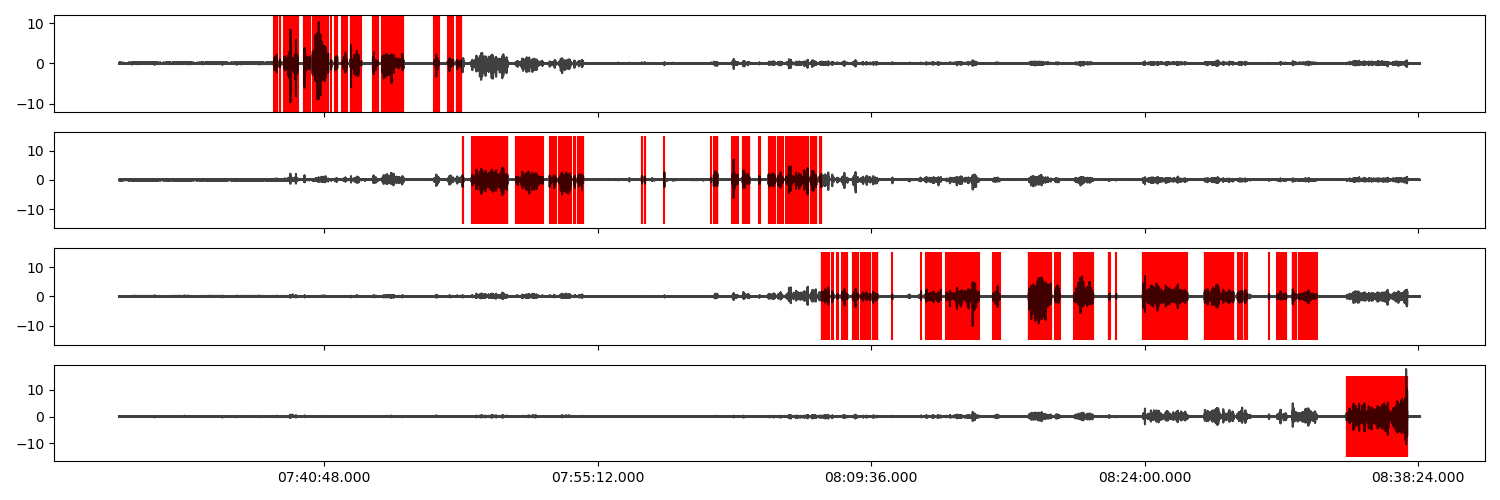

In [3]:
fig, axes = plt.subplots(4, 1, figsize=(15, 5), sharex=True)

for n, ax in enumerate(axes):
    data = day141_snapshot[n+2]
    ax.plot(data.times('matplotlib'), data.data, color='black', alpha=0.75)
    h_id = list(detector_data.keys())[n]
    # ax.vlines(x=get_event_times('h3'), ymin=-15, ymax=15, color='red')
    ax.vlines(x=get_event_times(h_id), ymin=-15, ymax=15, color='red')


axes[0].set_ylim(-12, 12)
axes[-1].xaxis.set_major_formatter(plotting.PrecisionDateFormatter("%H:%M:%S.{ms}"))
fig.tight_layout()

In [4]:
df = pd.DataFrame()
for h in detector_data.keys():
    df_temp = pd.DataFrame()
    df_temp['event_times (mpl)'] = detector_data[h]['event_times']
    df_temp['event_times (abs)'] = detector_data[h]['event_times (abs)']
    df_temp['hphone_idx'] = h
    df = pd.concat([df, df_temp])
    
df['ones'] = 1
df['event_times'] = df['event_times (mpl)'].apply(dates.num2date)
df.reset_index(inplace=True)

In [5]:
df['event_times (abs)'][0]

2019-05-21T07:38:10.208000Z

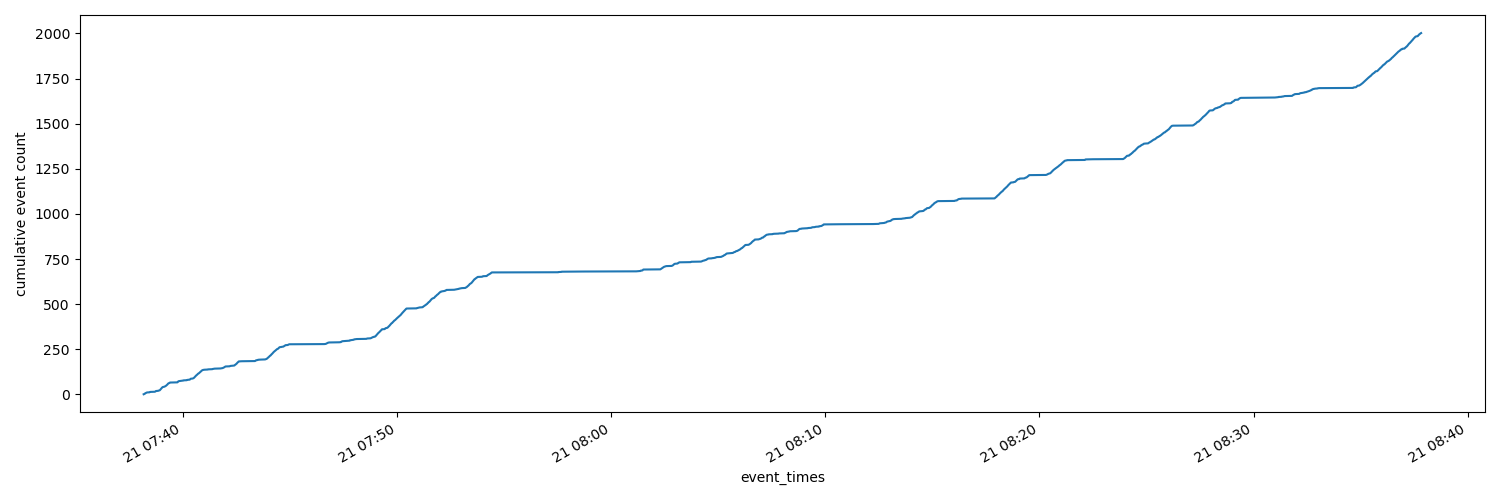

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))

df.set_index('event_times').ones.cumsum().plot(ax=ax)
ax.set_ylabel('cumulative event count')

fig.tight_layout()

0.133 148.4375
0.102 179.6875
0.1 304.6875
[ 148.4375  179.6875  304.6875]


/tmp/ipykernel_17966/3812650805.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolormesh(time, freq, spec, cmap='nipy_spectral')


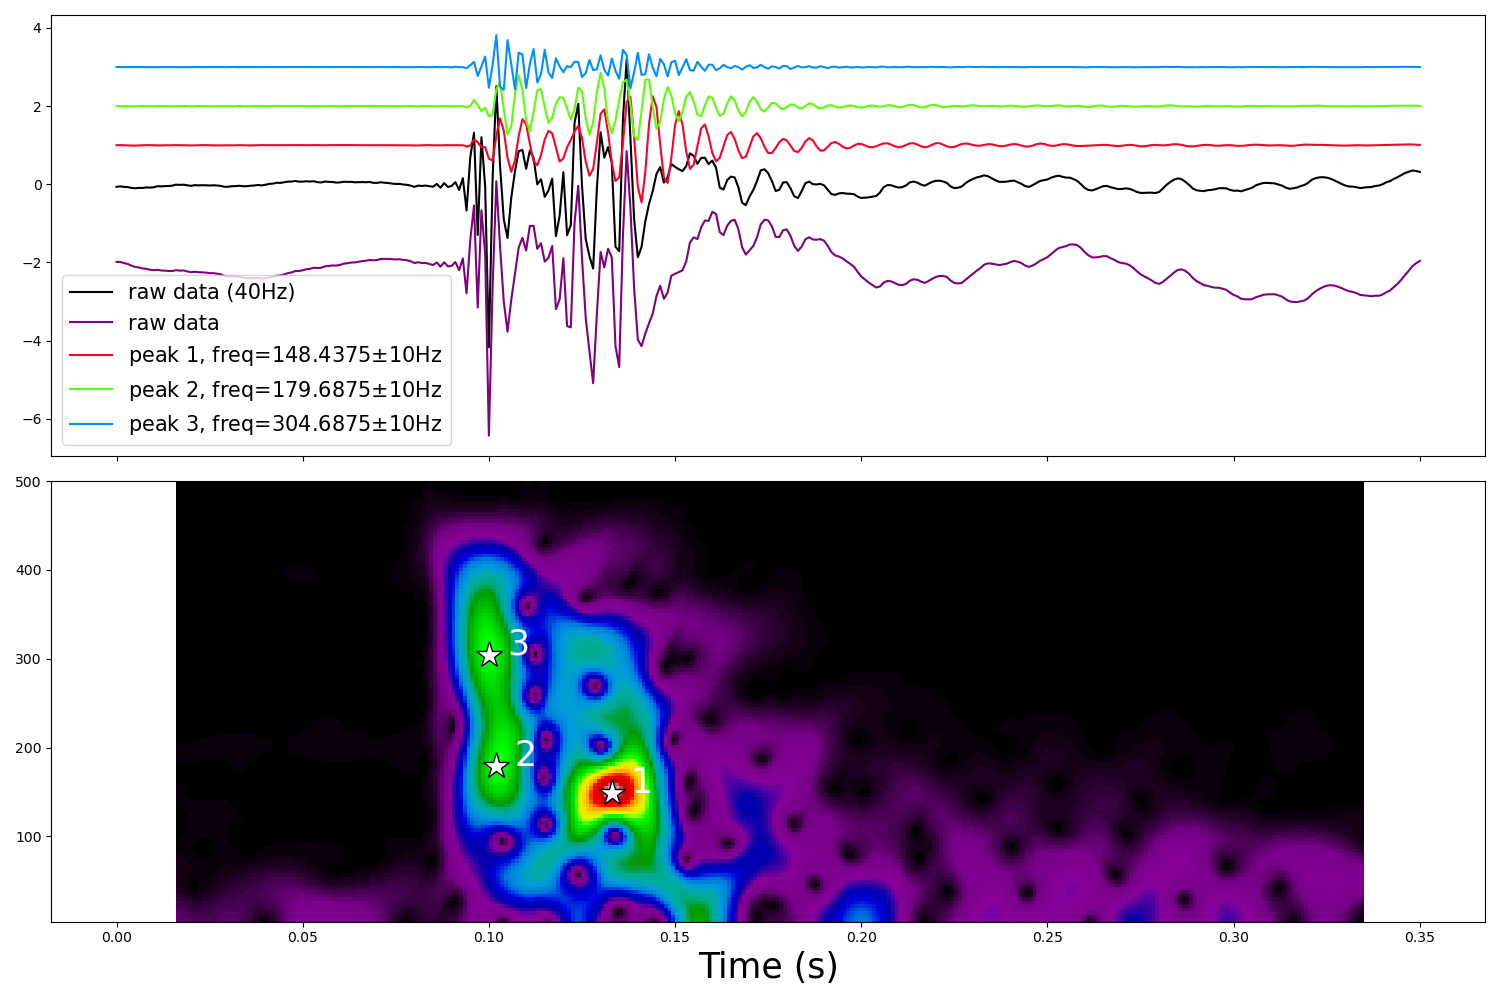

In [17]:
event = get_event_window(df['event_times (abs)'].iloc[92], hydrophone='h3')
spec, freq, time = signal_processing.spectrogram(event.data, samp_rate=1000, cmap='nipy_spectral', per_lap=0.999, log=True)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15, 10))
ax[0].plot(event.times(), event.data, label='raw data (40Hz)', color='black')

event_raw = get_event_window_raw(df['event_times (abs)'].iloc[92], hydrophone='h3')
ax[0].plot(event_raw.times(), event_raw.data-2, label='raw data', color='purple')

ax[1].pcolormesh(time, freq, spec, cmap='nipy_spectral')


def get_geq_hist(spec, geq=95):
    spec = spec.flatten()
    h, e = np.histogram(spec, bins=100)
    geq = -100 + geq
    return e[geq]

geq95 = get_geq_hist(spec, geq=50)
xy = peak_local_max(spec, min_distance=2, threshold_abs=geq95)
freqs = freq[xy[:,0]]
times = time[xy[:,1]]
ax[1].plot(times, freqs, marker='*', color='white', markeredgecolor='black', linewidth=0, markersize=20)

n = 1
for y, x in xy:
    y = freq[y]
    x = time[x]
    print(x, y)
    ax[1].text(s=str(n), x=x+0.005, y=y, color='white', fontsize=25, zorder=50)
    n+=1

for n, freq in enumerate(freqs):
    # locpass = event.copy()
    locpass = event_raw.copy()
    locpass.filter(type='bandpass', zerophase=False, corners=1, freqmin=freq-10, freqmax=freq+10)
    ax[0].plot(locpass.times(), locpass.data+n+1, label='peak {n}, freq={f}$\pm$10Hz'.format(n=n+1, f=freq), color=plt.cm.gist_rainbow(n/freqs.shape[0]))
    
ax[0].legend(fontsize=15)
ax[1].set_xlabel('Time (s)', fontsize=25)

fig.tight_layout()
print(freqs)

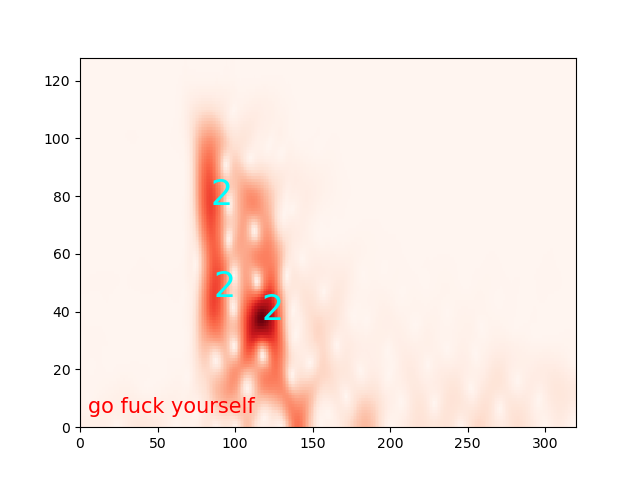

In [20]:
fig, ax = plt.subplots()

ax.text(s='go fuck yourself', x=5, y=5, fontsize=15, color='red')
for x, y in xy:
    ax.text(s=str(n), x=y+0.02, y=x+0.02, color='cyan', fontsize=25, zorder=50)
ax.pcolormesh(spec, cmap='Reds')

In [9]:
for n, x1y1 in enumerate(xy):
    print(n, x, y)
    
xy

0 66 85
1 66 85


array([[39, 87],
       [66, 85]])

In [108]:
geq95

0.088949014392975811

In [107]:
spec.max()

0.10981359485719119

(array([  1.33200000e+04,   3.33800000e+03,   2.14600000e+03,
          1.56400000e+03,   1.31900000e+03,   1.15900000e+03,
          9.14000000e+02,   9.73000000e+02,   9.39000000e+02,
          8.28000000e+02,   7.35000000e+02,   6.70000000e+02,
          6.55000000e+02,   5.19000000e+02,   5.35000000e+02,
          4.84000000e+02,   5.18000000e+02,   5.29000000e+02,
          4.41000000e+02,   4.27000000e+02,   4.14000000e+02,
          3.65000000e+02,   2.98000000e+02,   3.15000000e+02,
          2.63000000e+02,   2.90000000e+02,   2.45000000e+02,
          2.46000000e+02,   2.68000000e+02,   2.30000000e+02,
          2.05000000e+02,   2.26000000e+02,   2.14000000e+02,
          1.98000000e+02,   2.28000000e+02,   1.95000000e+02,
          1.77000000e+02,   1.81000000e+02,   1.91000000e+02,
          1.60000000e+02,   1.70000000e+02,   1.60000000e+02,
          1.75000000e+02,   1.62000000e+02,   1.29000000e+02,
          1.37000000e+02,   1.43000000e+02,   1.31000000e+02,
        

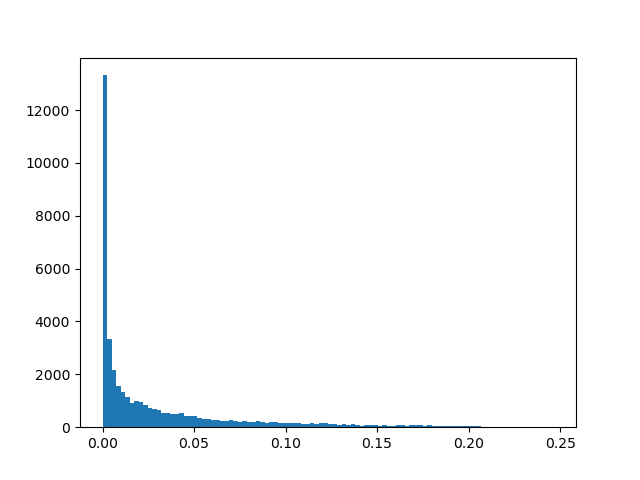

In [96]:
fig, ax = plt.subplots()
ax.hist(spec.flatten(), bins=100)

In [76]:
time.shape

(320,)

In [78]:
freq.shape

(128,)

In [96]:
# samp_rate = float(samp_rate)

# # set wlen from samp_rate if not specified otherwise
# # if not wlen:
# wlen = samp_rate / 100.

# npts = len(data)
# # nfft needs to be an integer, otherwise a deprecation will be raised
# # XXX add condition for too many windows => calculation takes for ever
# nfft = int(_nearest_pow_2(wlen * samp_rate))
# if nfft > npts:
#     nfft = int(_nearest_pow_2(npts / 8.0))

# if mult is not None:
# mult = int(_nearest_pow_2(mult))
# mult = mult * nfft
# nlap = int(nfft * float(per_lap))

# data = data - data.mean()
# end = npts / samp_rate

# # Here we call not plt.specgram as this already produces a plot
# # matplotlib.mlab.specgram should be faster as it computes only the
# # arrays
# # XXX mlab.specgram uses fft, would be better and faster use rfft
# specgram, freq, time = mlab.specgram(data, Fs=samp_rate, NFFT=nfft,
#                                  pad_to=mult, noverlap=nlap)

IndentationError: expected an indented block (3647685560.py, line 5)

In [107]:
# def power_log(x):
#     import math
#     return 2**(math.ceil(math.log(x, 2)))

# power_log(1025)

2048

In [ ]:
# import matplotlib as mpl

# def calc_specgram(data, sample_rate):
#     sample_rate = float(sample_rate)
#     if not wlen:
#         wlen = sample_rate / 100

/tmp/ipykernel_23493/1626272373.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(time, freq, specgram, cmap='Spectral')


4

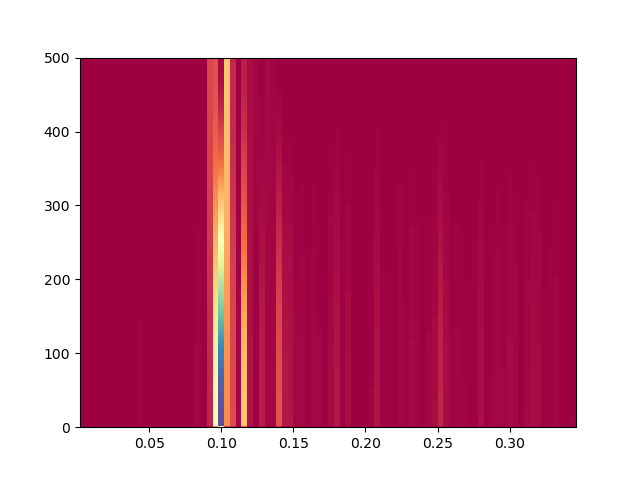

In [165]:
# x = get_event_window(df['event_times (abs)'].iloc[93], hydrophone='h3')

# # fig, ax = plt.subplots()

# sample_rate = 1000
# wlen = sample_rate/100.
# npts = x.data.shape[0]
# nfft = int(power_log(wlen * sample_rate))
# if nfft > npts:
#     nfft = int(power_log(npts/128))
    
# mult = 128 * nfft
# perlap = 0.1
# nlap = int(nfft * float(perlap))

# data = x.data
# data = data - data.mean()

# from matplotlib import mlab
# specgram, freq, time = mlab.specgram(data, Fs=sample_rate, NFFT=nfft, pad_to=mult, noverlap=nlap)

# fig, ax = plt.subplots()
# ax.pcolormesh(time, freq, specgram, cmap='Spectral')
# nfft

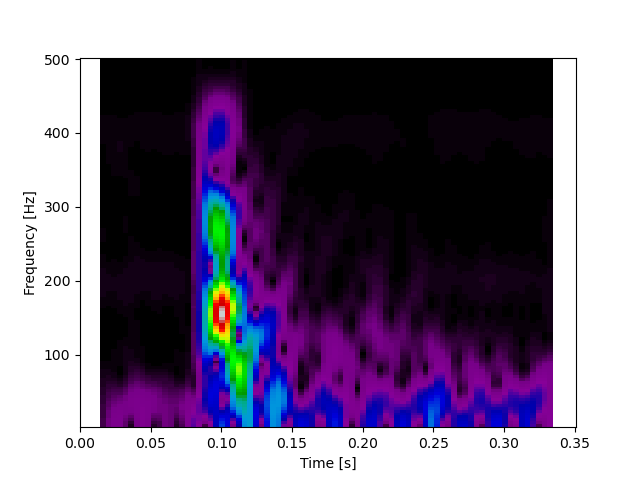

In [177]:
from obspy.imaging.spectrogram import spectrogram
x = get_event_window(df['event_times (abs)'].iloc[93], hydrophone='h3')

spectrogram(x.data, samp_rate=1000, cmap='nipy_spectral')

In [182]:
# # -*- coding: utf-8 -*-
# # ------------------------------------------------------------------
# # Filename: spectrogram.py
# #  Purpose: Plotting spectrogram of Seismograms.
# #   Author: Christian Sippl, Moritz Beyreuther
# #    Email: sippl@geophysik.uni-muenchen.de
# #
# # Copyright (C) 2008-2012 Christian Sippl
# # --------------------------------------------------------------------
# """
# Plotting spectrogram of seismograms.

# :copyright:
#     The ObsPy Development Team (devs@obspy.org)
# :license:
#     GNU Lesser General Public License, Version 3
#     (https://www.gnu.org/copyleft/lesser.html)
# """
# import os
# import math

# import numpy as np
# from matplotlib import mlab
# from matplotlib.colors import Normalize

# from obspy.imaging.cm import obspy_sequential


# def _nearest_pow_2(x):
#     """
#     Find power of two nearest to x

#     >>> _nearest_pow_2(3)
#     2.0
#     >>> _nearest_pow_2(15)
#     16.0

#     :type x: float
#     :param x: Number
#     :rtype: int
#     :return: Nearest power of 2 to x
#     """
#     a = math.pow(2, math.ceil(np.log2(x)))
#     b = math.pow(2, math.floor(np.log2(x)))
#     if abs(a - x) < abs(b - x):
#         return a
#     else:
#         return b



# def spectrogram(data, samp_rate, per_lap=0.9, wlen=None, log=False,
#                 outfile=None, fmt=None, axes=None, dbscale=False,
#                 mult=8.0, cmap=obspy_sequential, zorder=None, title=None,
#                 show=True, clip=[0.0, 1.0]):
#     """
#     Computes and plots spectrogram of the input data.

#     :param data: Input data
#     :type samp_rate: float
#     :param samp_rate: Samplerate in Hz
#     :type per_lap: float
#     :param per_lap: Percentage of overlap of sliding window, ranging from 0
#         to 1. High overlaps take a long time to compute.
#     :type wlen: int or float
#     :param wlen: Window length for fft in seconds. If this parameter is too
#         small, the calculation will take forever. If None, it defaults to
#         (samp_rate/100.0).
#     :type log: bool
#     :param log: Logarithmic frequency axis if True, linear frequency axis
#         otherwise.
#     :type outfile: str
#     :param outfile: String for the filename of output file, if None
#         interactive plotting is activated.
#     :type fmt: str
#     :param fmt: Format of image to save
#     :type axes: :class:`matplotlib.axes.Axes`
#     :param axes: Plot into given axes, this deactivates the fmt and
#         outfile option.
#     :type dbscale: bool
#     :param dbscale: If True 10 * log10 of color values is taken, if False the
#         sqrt is taken.
#     :type mult: float
#     :param mult: Pad zeros to length mult * wlen. This will make the
#         spectrogram smoother.
#     :type cmap: :class:`matplotlib.colors.Colormap`
#     :param cmap: Specify a custom colormap instance. If not specified, then the
#         default ObsPy sequential colormap is used.
#     :type zorder: float
#     :param zorder: Specify the zorder of the plot. Only of importance if other
#         plots in the same axes are executed.
#     :type title: str
#     :param title: Set the plot title
#     :type show: bool
#     :param show: Do not call `plt.show()` at end of routine. That way, further
#         modifications can be done to the figure before showing it.
#     :type clip: [float, float]
#     :param clip: adjust colormap to clip at lower and/or upper end. The given
#         percentages of the amplitude range (linear or logarithmic depending
#         on option `dbscale`) are clipped.
#     """
#     import matplotlib.pyplot as plt
#     # enforce float for samp_rate
#     samp_rate = float(samp_rate)

#     # set wlen from samp_rate if not specified otherwise
#     if not wlen:
#         wlen = samp_rate / 100.

#     npts = len(data)
#     # nfft needs to be an integer, otherwise a deprecation will be raised
#     # XXX add condition for too many windows => calculation takes for ever
#     nfft = int(_nearest_pow_2(wlen * samp_rate))
#     if nfft > npts:
#         nfft = int(_nearest_pow_2(npts / 8.0))

#     if mult is not None:
#         mult = int(_nearest_pow_2(mult))
#         mult = mult * nfft
#     nlap = int(nfft * float(per_lap))

#     data = data - data.mean()
#     end = npts / samp_rate

#     # Here we call not plt.specgram as this already produces a plot
#     # matplotlib.mlab.specgram should be faster as it computes only the
#     # arrays
#     # XXX mlab.specgram uses fft, would be better and faster use rfft
#     specgram, freq, time = mlab.specgram(data, Fs=samp_rate, NFFT=nfft,
#                                          pad_to=mult, noverlap=nlap)
#     # db scale and remove zero/offset for amplitude
#     if dbscale:
#         specgram = 10 * np.log10(specgram[1:, :])
#     else:
#         specgram = np.sqrt(specgram[1:, :])
#     freq = freq[1:]

#     return specgram, freq, time

In [184]:
# spec, freq, time = spectrogram(x.data, samp_rate=1000)

/tmp/ipykernel_23493/4126422013.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(time, freq, spec)


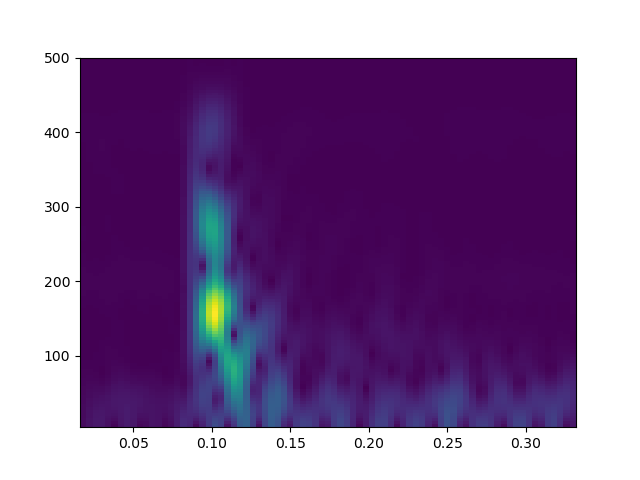

In [185]:
# fig, ax = plt.subplots()
# ax.pcolormesh(time, freq, spec)

In [95]:


x = get_event_window(df['event_times (abs)'].iloc[93], hydrophone='h3')
# fig, ax = plt.subplots(2, 1, sharex=True)

# ax[0].plot(x.times('matplotlib'), x.data)
# # ax[1].specgram(x.data, Fs=1000, NFFT=1024, nlap=1024*2)
# ''
# x.plot(axes=ax[0])
# x.spectrogram(axes=ax[1])
x

7F.A00.03.GDH | 2019-05-21T07:40:33.595000Z - 2019-05-21T07:40:33.945000Z | 1000.0 Hz, 351 samples

In [73]:
plt.spectrogram

AttributeError: module 'matplotlib.pylab' has no attribute 'spectrogram'

In [90]:
# start = obspy.UTCDateTime(df.sample(1).event_times.values[0])
# day141_snapshot.slice(starttime=)
df.sample(1).event_times.values[0].

numpy.datetime64('2019-05-21T08:28:30.065000000')

In [55]:
df['ones'] = 1

pd.to_datetime(df['event_times (mpl)']*1e13)

0     1975-09-19 15:39:41.737152768
1     1975-09-19 15:39:41.889583328
2     1975-09-19 15:39:42.031712960
3     1975-09-19 15:39:42.192361120
4     1975-09-19 15:39:42.311458336
                   ...             
308   1975-09-19 15:46:35.635532416
309   1975-09-19 15:46:35.704976832
310   1975-09-19 15:46:35.782986112
311   1975-09-19 15:46:35.892708320
312   1975-09-19 15:46:35.991435168
Name: event_times (mpl), Length: 2068, dtype: datetime64[ns]

In [70]:
import matplotlib as mpl
mpl.dates.num2date(df['event_times (mpl)'].iloc[0])

datetime.datetime(2019, 5, 21, 7, 38, 10, 209000, tzinfo=datetime.timezone.utc)

In [67]:
obspy.UTCDateTime(df['event_times (mpl)'].iloc[0]*8.5e4)

2018-08-02T01:07:24.765799Z

In [16]:
h3 = day141_snapshot.slice(starttime=detector_times['h3']['start']
                     ,endtime=detector_times['h3']['end'])[2]

h3_idx, h3_props = peak_finder(obspydata=h3, height=0.5, distance=250)

detector_data['h3']['event_times'] = h3.times('matplotlib')[h3_index]

In [ ]:
h4 = day141_snapshot.slice(starttime=detector_times['h4']['start']
                     ,endtime=detector_times['h4']['end'])[3]

h4_idx, h4_props = peak_finder(obspydata=h4, height=0.5, distance=250)

In [ ]:
h5 = day141_snapshot.slice(starttime=detector_times['h5']['start']
                     ,endtime=detector_times['h5']['end'])[4]

h5_idx, h5_props = peak_finder(obspydata=h5, height=0.5, distance=250)

In [ ]:
h6 = day141_snapshot.slice(starttime=detector_times['h6']['start']
                     ,endtime=detector_times['h6']['end'])[5]

h6_idx, h6_props = peak_finder(obspydata=h6, height=0.5, distance=250)

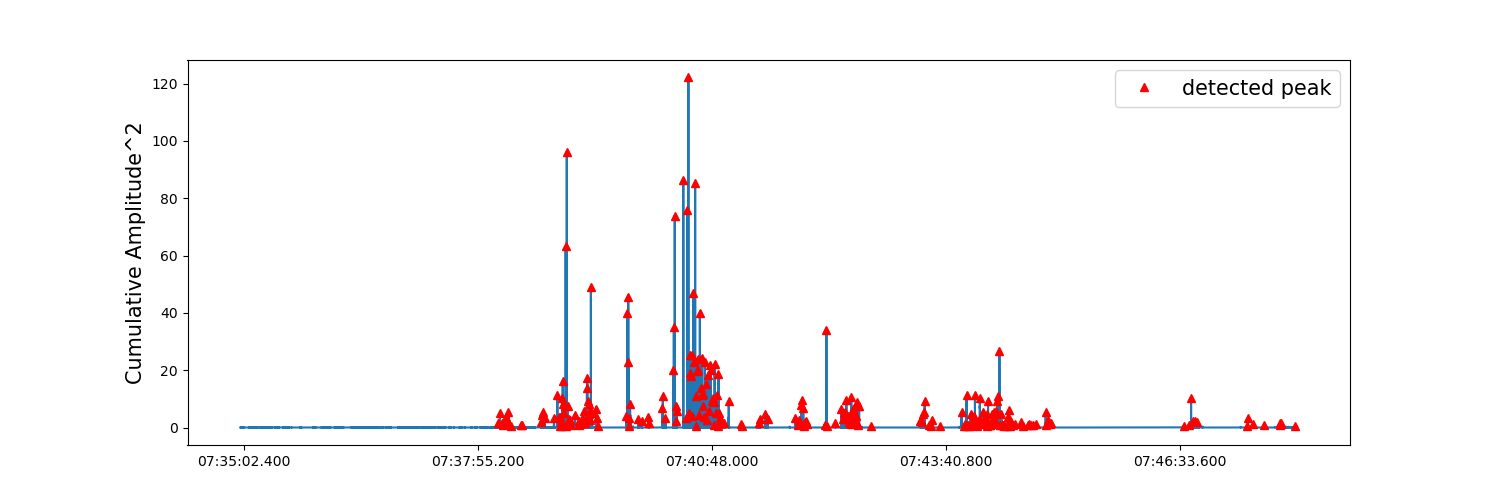

In [9]:
h3 = day141_snapshot.slice(starttime=detector_times['h3']['start']
                     ,endtime=detector_times['h3']['end'])[2]
h3_peaks_idx, props = signal.find_peaks(h3.data**2, height=0.5, distance=250)
h3_peak_heights = props['peak_heights']

fig, ax = plt.subplots(1, figsize=(15, 5), sharex=True, sharey=True)

ax.plot(h3.times('matplotlib'), h3.data**2)

t = h3.times('matplotlib')[h3_peaks_idx]
ax.plot(t, h3_peak_heights, marker='^', color='red', linewidth=0, label='detected peak')
ax.xaxis.set_major_formatter(plotting.PrecisionDateFormatter("%H:%M:%S.{ms}"))
ax.set_ylabel('Cumulative Amplitude^2', fontsize=15)
ax.legend(fontsize=15)

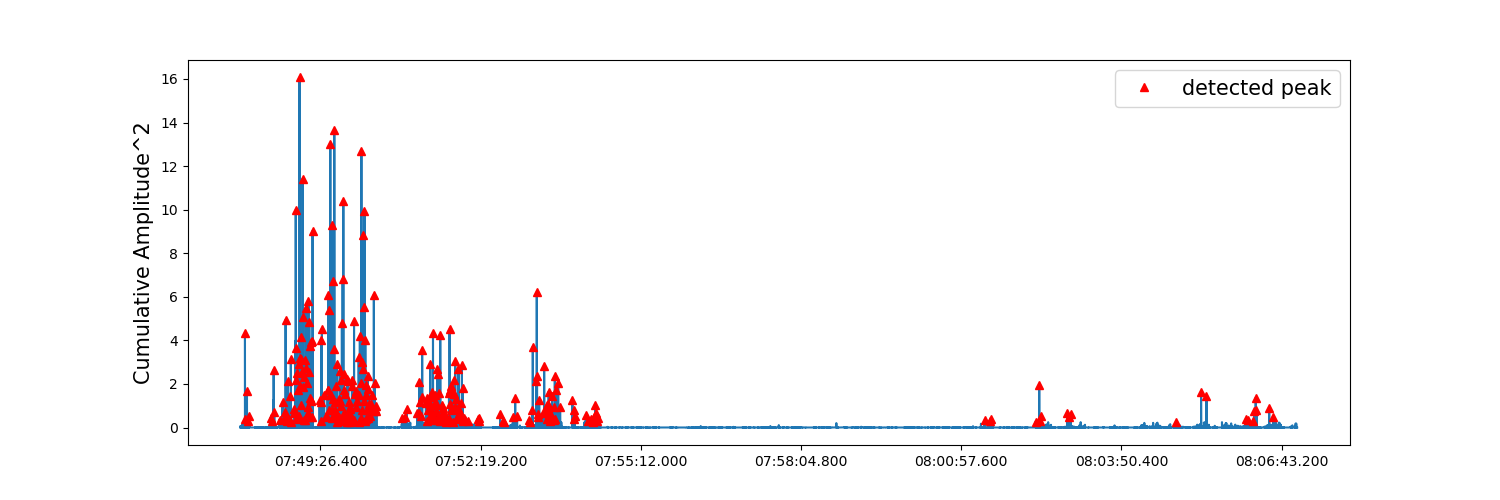

In [11]:
h4 = day141_snapshot.slice(starttime=detector_times['h4']['start']
                     ,endtime=detector_times['h4']['end'])[2]
h4_peaks_idx, props = signal.find_peaks(h4.data**2, height=0.25, distance=250)
h4_peak_heights = props['peak_heights']

fig, ax = plt.subplots(1, figsize=(15, 5), sharex=True, sharey=True)

ax.plot(h4.times('matplotlib'), h4.data**2)

t = h4.times('matplotlib')[h4_peaks_idx]
ax.plot(t, h4_peak_heights, marker='^', color='red', linewidth=0, label='detected peak')
ax.xaxis.set_major_formatter(plotting.PrecisionDateFormatter("%H:%M:%S.{ms}"))
ax.set_ylabel('Cumulative Amplitude^2', fontsize=15)
ax.legend(fontsize=15)

In [40]:
# h3_peaks_idx

array([190209, 191526, 192754, 196266, 197408, 197913, 221564, 222929,
       223555, 224521, 231477, 233973, 235318, 236239, 236655, 237608,
       237925, 238508, 238814, 239501, 240081, 240927, 241764, 242359,
       243062, 247067, 249682, 250893, 252165, 252777, 253361, 253974,
       254699, 255258, 255791, 256094, 256643, 257176, 257532, 257946,
       258235, 258720, 259549, 262693, 263458, 284894, 285506, 285756,
       286317, 287123, 287677, 293622, 296103, 301139, 301643, 311416,
       311804, 313754, 319378, 319932, 320611, 321231, 321509, 322015,
       326936, 328754, 329765, 330698, 331127, 331650, 332131, 332623,
       333135, 333695, 334236, 334871, 335682, 336228, 336935, 337573,
       337924, 338385, 339148, 339816, 340437, 340795, 341325, 341762,
       342103, 342713, 343966, 344696, 345261, 345797, 346647, 347255,
       348167, 348685, 349227, 350047, 350822, 351508, 352888, 353585,
       354263, 355808, 357133, 360464, 369798, 382628, 383390, 387511,
      

In [41]:
# h3_peak_heights = props['peak_heights']
# h3_peak_heights

array([   1.62647726,    4.90200619,    1.68657048,    3.55037077,
          1.96560848,    5.46472005,    2.04372158,    4.44417421,
          5.35279232,    3.31068484,    3.21946174,   11.29656108,
          3.6313752 ,    3.55166023,    1.95144125,   10.17644911,
         16.20034982,    8.33131166,    5.14720314,    7.59434489,
         63.21506509,   96.17723156,    7.67044105,    2.88200753,
          2.70606212,    4.22125603,    2.20345377,    1.3832465 ,
          2.82583706,    2.53318022,    2.10079013,    5.69816781,
          1.51912119,    2.7383496 ,   13.81367439,   17.27712099,
          9.25012718,    4.67066441,    8.17782423,    2.50774264,
          5.800985  ,   48.91756678,    4.92553027,    6.56056683,
          3.47259042,    3.97290132,   39.91301983,   22.94104781,
         45.5029354 ,    3.45979093,    8.33578576,    3.07810329,
          2.13848397,    3.82159704,    1.46340278,    6.72825232,
         11.06434903,    3.42112139,   20.22670088,   35.02078

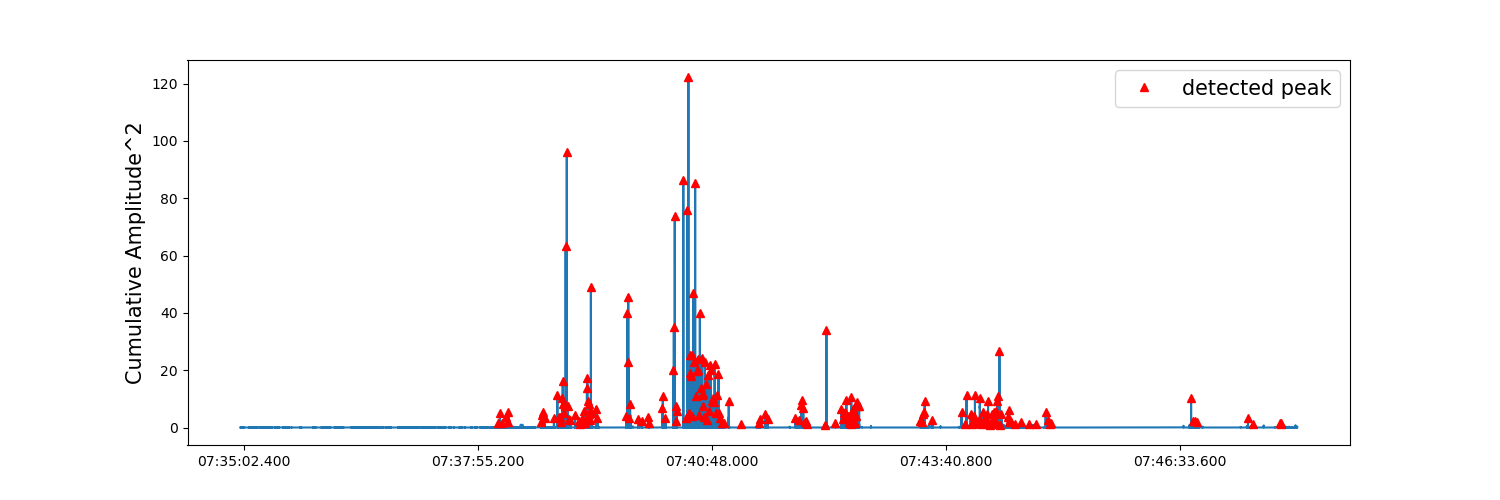

In [37]:
# np.sqrt(0.99999)

0.99999499998749997

In [18]:
# if type(h3) == obspy.core.trace.Trace:
#     print('wtf')

wtf


In [6]:
staltas = {}

sample_rate = day141_snapshot[2].stats.sampling_rate

for n, d in enumerate(detector_times.items()):
    start = obspy.UTCDateTime(d[1]['start'])
    end = obspy.UTCDateTime(d[1]['end'])
    hydrophone_n = n + 3
    
    data = day141_snapshot[n+2].copy()
    data = data.slice(starttime=start, endtime=end)    
    
    # cft = classic_sta_lta(data, nsta=1*sample_rate, nlta=10*sample_rate)
    # trigger_onset(cft, thres1=1.25*2, thres2=1.25, max_len=2*sample_rate)
   
    
    
    cft = classic_sta_lta(data, nsta=1*sample_rate, nlta=2*sample_rate)
    trigger = trigger_onset(cft, thres1=1.25, thres2=1.15, max_len=2*sample_rate)

    # cft = z_detect(data, nsta=int(1*sample_rate))
    # trigger = trigger_onset(cft, thres1=-0.2, thres2=-0.4)
    
    staltas[d[0]] = {
        'start':start
        ,'end':end
        ,'cft':cft
        ,'trigger':trigger
        ,'data':data
    }

In [7]:
data

7F.A00.06.GDH | 2019-05-21T08:34:00.000000Z - 2019-05-21T08:38:00.000000Z | 1000.0 Hz, 240001 samples

In [8]:
staltas.keys()

dict_keys(['h3', 'h4', 'h5', 'h6'])

In [9]:
staltas['h3'].keys()

dict_keys(['start', 'end', 'cft', 'trigger', 'data'])

2019-05-21T07:35:00.000000Z
(1,)
2019-05-21T07:48:00.000000Z
(84,)
2019-05-21T08:07:00.000000Z
(1,)
2019-05-21T08:34:00.000000Z
(32,)


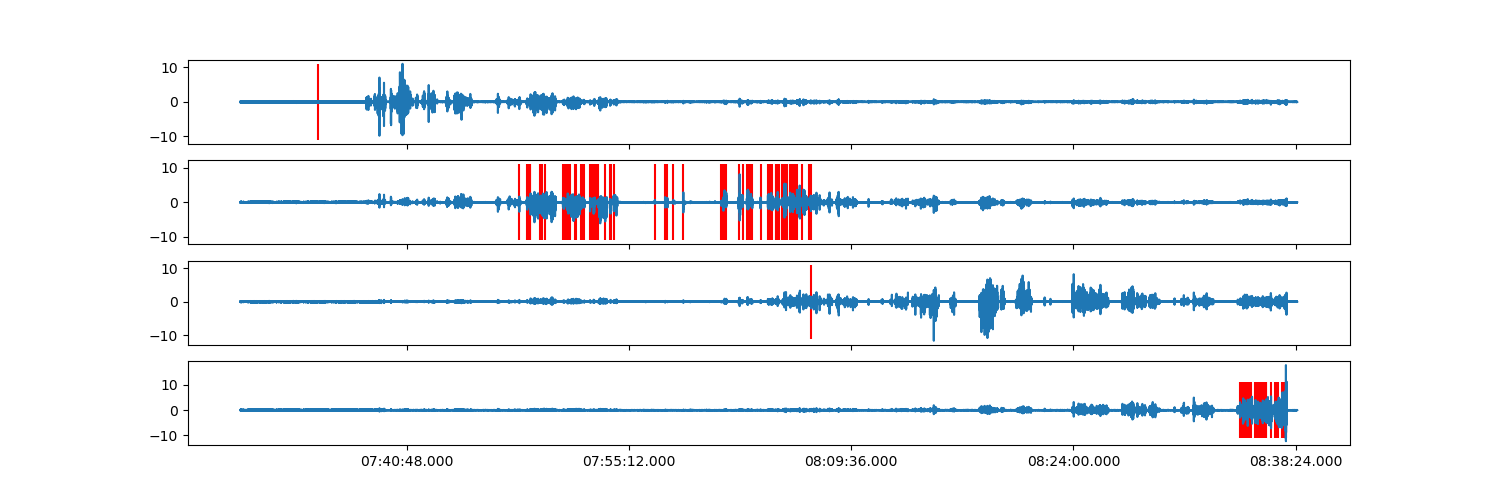

In [10]:
fig, ax = plt.subplots(4, 1, figsize=(15, 5), sharex=True)

for n, tr in enumerate(day141_snapshot[2:]):
    ax[n].plot(tr.times('matplotlib'), tr.data)


for n, h in enumerate(staltas.keys()):
    data = staltas[h]['data']
    times = data.times('matplotlib')
    
    on_t = times[staltas[h]['trigger'][:,0]]
    off_t = times[staltas[h]['trigger'][:,1]]
    
    ax[n].vlines(on_t, -11, 11, color='red')
    # break
    print(staltas[h]['start'])
    print(on_t.shape)
ax[n].xaxis.set_major_formatter(plotting.PrecisionDateFormatter("%H:%M:%S.{ms}"))


In [11]:
staltas

{'h3': {'start': 2019-05-21T07:35:00.000000Z,
  'end': 2019-05-21T07:48:00.000000Z,
  'cft': array([-0.30030031, -0.30030031, -0.30030031, ..., -0.25501106,
         -0.25500301, -0.25500126]),
  'trigger': array([[  1000, 780000]]),
  'data': 7F.A00.03.GDH | 2019-05-21T07:35:00.000000Z - 2019-05-21T07:48:00.000000Z | 1000.0 Hz, 780001 samples},
 'h4': {'start': 2019-05-21T07:48:00.000000Z,
  'end': 2019-05-21T08:07:00.000000Z,
  'cft': array([-0.50932476, -0.50932476, -0.50932476, ..., -0.40018366,
         -0.41172753, -0.41351824]),
  'trigger': array([[   4988,    6121],
         [  34230,   37659],
         [  43042,   43960],
         [  45514,   46775],
         [  46958,   79002],
         [  85511,   89127],
         [  90387,   92218],
         [  92712,  105588],
         [ 105917,  147944],
         [ 174321,  176764],
         [ 177493,  179057],
         [ 179608,  181491],
         [ 181865,  183025],
         [ 183352,  184408],
         [ 190063,  191810],
         [ 1

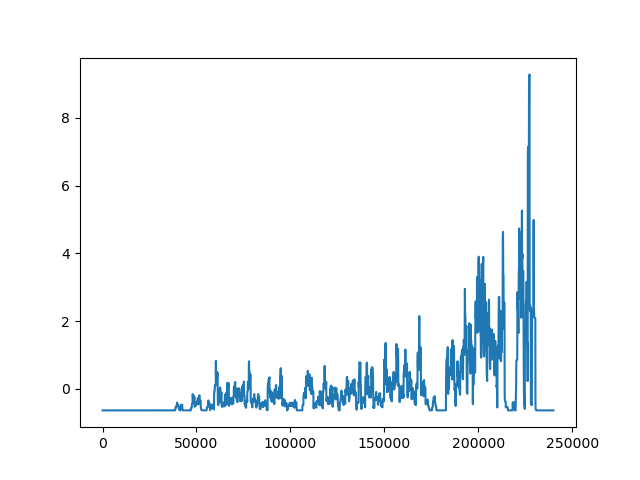

In [12]:
fig, ax = plt.subplots()
ax.plot(cft)